<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> RAMP on charged particle tracking with ATLAS detector </h2>

<i> Thomas Boser, Mikhail Hushchyn, Balázs Kégl, David Rousseau, Yetkin Yılmaz </i>

<h2> Introduction </h2>

<p> 

<p>The main objective is to achive the optimal assignment of each hit to a track id.



### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)  

In [6]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [7]:
filename = "data/hits_merged.csv"
df = pd.read_csv(filename)
y_df = df[['particle']] + 1000 * df[['event']].values
X_df = df.drop(['particle'], axis=1)

(particle ids are shifted by 1000 times the event id, in order to make them unique across the dataset)

### Looping over events

In [10]:
y_events = df['event'].values

In [11]:
events = np.unique(y_events)

### Visualize the hits in a single event

In [12]:
ievent = 0
X_df_event = X_df.loc[X_df['event']==ievent]
pixelx = X_df_event['x'].values
pixely = X_df_event['y'].values
particles = y_df.loc[X_df['event']==ievent]['particle'].values

#### Hits from all particles

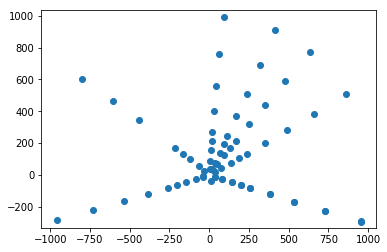

In [13]:
plt.scatter(pixelx,pixely)
plt.axis('equal')
plt.show()

This is what the algorithm will see.

#### Hits from a single particle

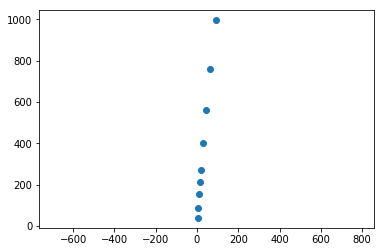

In [14]:
iparticle = 2
iparticle += ievent * 1000
hits_particle = (particles == iparticle)
plt.scatter(pixelx[hits_particle],pixely[hits_particle])
plt.axis('equal')
plt.show()

So, ideally, our algorithm wants to assign specific ids to all hits in a way that corresponds to the particle. The perfect algorithm will split the event into various tracks:

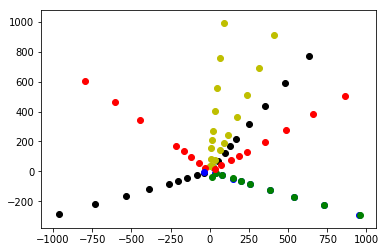

In [15]:
cmap = ['k','b','y','g','r']
for iparticle in np.unique(particles):
    hits_particle = (particles == iparticle)
    plt.scatter(pixelx[hits_particle],pixely[hits_particle],color=cmap[int(iparticle) % 5])
plt.show()

### Matching the hits together

In [16]:
import Hough
tracker = Hough.Hough(n_theta_bins=100, n_radius_bins=100, min_radius=1., min_hits=4)

In [17]:
import NearestHit
tracker = NearestHit.NearestHit(min_cos_value=0.9)

In [18]:
import LinearApproximation
tracker = LinearApproximation.LinearApproximation(min_hits=4, window_width=0.03)

#### Training the algorithm

In [19]:
tracker.fit(X_df.values, y_df.values)

#### Running the algorithm to reconstruct the tracks in data

In [20]:
y_true = y_df['particle'].values
y_predicted = tracker.predict(X_df.values)

In [21]:
y_df['track'] = y_predicted

Let's compare how well the tracks corresponds to the particles

In [22]:
y_df[(X_df['event']==7).values].sort(['particle'])

,particle,track
567,7000,-1
564,7000,5
566,7000,5
570,7000,5
589,7000,-1
588,7000,5
581,7000,5
576,7000,-1
548,7000,5
552,7001,0


In [23]:
tracks = y_predicted[(X_df['event']==ievent).values]

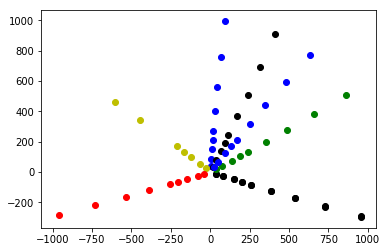

In [24]:
cmap = ['k','b','y','g','r']
for itrack in np.unique(tracks):
    if itrack >= 0:
        hits_track = (tracks == itrack)
        plt.scatter(pixelx[hits_track],pixely[hits_track],color=cmap[int(itrack) % 5])
plt.show()

### Scoring the assignment

The score function measures the fraction of hits with good track assignment

In [25]:
def score(y_test, y_pred):

    total_score = 0.
    y_events = y_test[:,1]
    y_test = y_test[:,0]
    y_pred = y_pred[:,0]

    events = np.unique(y_events)
    for ievent in events:
        eff_total = 0.
        event_indices=(y_events==ievent)
        y_test_event = y_test[event_indices]
        y_pred_event = y_pred[event_indices]

        particles = np.unique(y_test_event)
        npart = len(particles)
        nhit = len(y_test_event)
        dummyarray = np.full(shape=nhit + 1,fill_value=-1, dtype='int64')

        assignedtrack = np.full(shape=npart,fill_value=-1, dtype='int64')
        hitintrack = np.full(shape=npart,fill_value=0, dtype='int64')
        eff = np.full(shape=npart,fill_value=0.)
        con = np.full(shape=npart,fill_value=0.)

        # assign tracks to particles
        ipart = 0
        for particle in particles:
            
            eff[ipart] = 0.
            con[ipart] = 0.

            true_hits = y_test_event[y_test_event[:] == particle]
            found_hits = y_pred_event[y_test_event[:] == particle]

            nsubcluster=len(np.unique(found_hits[found_hits[:] >= 0]))

            if(nsubcluster > 0):
                b=np.bincount((found_hits[found_hits[:] >= 0]).astype(dtype='int64'))
                a=np.argmax(b)

                maxcluster = a

                assignedtrack[ipart]=maxcluster
                hitintrack[ipart]=len(found_hits[found_hits[:] == maxcluster])

            ipart += 1


        # resolve duplicates and count good assignments
        ipart = 0
        sorted=np.argsort(hitintrack)
        hitintrack=hitintrack[sorted]
        assignedtrack=assignedtrack[sorted]
        #    print hitintrack
        for particle in particles:
            itrack=assignedtrack[ipart]
            if((itrack < 0) | (len(assignedtrack[assignedtrack[:] == itrack])>1)):
                hitintrack = np.delete(hitintrack,ipart)
                assignedtrack = np.delete(assignedtrack,ipart)
            else:
                ipart += 1
        ngood = 0.
        ngood = np.sum(hitintrack)
        eff_total = eff_total + (float(ngood) / float(nhit))
        # remove combinatorials
        print npart, nhit, eff_total
  
        total_score += eff_total


    total_score /= len(y_events)


    return eff_total


In [37]:
len(y_true)

368092

In [33]:
y_t = np.zeros((len(y_events),2))
y_p = np.zeros((len(y_events),2))

y_t[:,0] = y_true
y_t[:,1] = y_events

y_p[:,0] = y_predicted
y_p[:,1] = y_events

score(y_t,y_p)

ValueError: could not broadcast input array from shape (368092) into shape (92023)

### Fitting the tracks (beyond the challenge)